In [2]:
# Import Libraries
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
import numpy as np
import os
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import MNIST, CIFAR10,FashionMNIST
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
import pylab as pl
from google.colab import files

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model_path = './ml_autoencoder.pth'

# Data and Preprocessing

We applied data augmentation to the training set, which included Gaussian blur and random affine transformations. Gaussian blur helps reduce noise, while random affine transformations introduce diversity. <br>
For the CIFAR dataset, we performed grayscale conversion and resizing.

In [3]:
# Transformations
transform_mnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

aug_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1)),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.01, 0.15),
                    scale=(0.9, 1.1), fill=-1)
])

cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),  # Resize to 28x28
])

In [4]:
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

In [5]:
# Datasets
trainset_aug = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=aug_transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform_mnist)
trainset, valset = train_test_split(trainset_aug, test_size=0.2, random_state=42)

ood = CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

# sample ~500-1000 samples from CIFAR
N = 1000
torch.manual_seed(0)
np.random.seed(0)

# sample indicies
ood_size = len(ood)
ood_idx = np.arange(ood_size)
ood_subset_idx = np.random.choice(ood_idx, N)
ood = [ood[i] for i in ood_subset_idx]

combined_ds = CombinedDataset(testset, ood)

100%|██████████| 9912422/9912422 [00:00<00:00, 68671035.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5420426.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19624783.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 772684.19it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:10<00:00, 15880129.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [27]:
# Data loaders
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_aug = DataLoader(trainset_aug, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
batch_size = 1024
combined_data_loader = DataLoader(combined_ds, batch_size=batch_size, shuffle=True)
#ood_loader = DataLoader(ood, batch_size=batch_size, shuffle=True)

# Models

We used a multi-task autoencoder as the base model for the OSR model. The autoencoder consists of an encoder-decoder architecture that learns to reconstruct the input data and also includes a classification head for predicting class labels. <br>
The OSR model takes the outputs of the base model and processes them further. It determines the level of uncertainty associated with each sample. If the OSR model detects significant uncertainty in the predictions and the reconstructions, it classifies those samples as "unknown."

In [7]:
# autoencoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.code_size = 12 # the size of the encoded vector
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32,self.code_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh())

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        return recon

# multi task autoencoder with a classification head
class ML_autoencoder(autoencoder):
    def __init__(self):
        super(ML_autoencoder, self).__init__()
        self.n_classes = 10
        # parameters saved for OSR prediction
        self.mean_entropy = nn.Parameter(torch.tensor([0.0]), requires_grad=False)
        self.mean_recon_loss = nn.Parameter(torch.tensor([0.0]), requires_grad=False)
        # self.mean_entropy = 0
        # self.mean_recon_loss = 0
        # classification head
        self.clf = nn.Sequential(
            nn.Linear(self.code_size, self.n_classes),
            )

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector)
        return recon, preds

    def set_prediction_params(self, mean_entropy, mean_loss_recon):
        self.mean_entropy.data = torch.tensor(mean_entropy)
        self.mean_recon_loss.data = torch.tensor(mean_loss_recon)

    def get_mean_entropy(self):
        return self.mean_entropy.item()

    def get_mean_recon_loss(self):
        return self.mean_recon_loss.item()

In [8]:
# This model uses a multi-task autoencoder as a base model,
# when predicting, it manipulates the predictions of the base model and returns the updates predictions
class ML_autoencoder_OSR(nn.Module):
    def __init__(self, trained_model=None):
        super(ML_autoencoder_OSR, self).__init__()
        self.trained_model = trained_model
        self.entropy_threshold = 0
        self.recon_threshold = 0
        self.temp = 0

    def set_prediction_params(self, entropy_threshold, recon_threshold, temp):
        self.entropy_threshold = entropy_threshold
        self.recon_threshold = recon_threshold
        self.temp = temp

    def forward(self, x):
        recon, preds = self.trained_model(x)
        predicted = self.get_updated_predictions(preds, self.temp,
                                                 self.entropy_threshold,
                                                 self.recon_threshold, x, recon)
        return recon, predicted

    # updates the predictions according to the level of uncertainty
    def get_updated_predictions(self, preds, temp, entropy_threshold, recon_threshold, x, recon):
        preds_softmax = self.softmax(preds.detach().cpu(), temp).to(device)
        max, argmax = torch.max(preds_softmax, dim=1)
        cls_indices = self.large_entropy(preds_softmax,entropy_threshold)
        recon_indices = self.large_loss_on_reconstruction(recon, x, recon_threshold)

        uncertain_indices =  cls_indices | recon_indices

        predicted = argmax
        predicted[uncertain_indices] = 10
        return predicted

    # returns true for indices of distributions with high entropies
    def large_entropy(self, probabilities,  entropy_threshold):
        distributions = torch.distributions.Categorical(probs=probabilities)
        entropies = distributions.entropy()
        uncertain_indices = (entropies > self.trained_model.get_mean_entropy() + self.entropy_threshold)
        return uncertain_indices

    # returns true for indices of samples with high reconstruction losses
    def large_loss_on_reconstruction(self, recon, x, recon_threshold):
        criterion = nn.MSELoss(reduction='none')
        loss = criterion(recon, x)
        loss = loss.mean(dim=1)
        recon_indices = (loss > self.trained_model.get_mean_recon_loss() + self.recon_threshold)
        return recon_indices


    def softmax(self, x, temp):
        exp_tensor = np.exp(x / self.temp)
        sum_exp = exp_tensor.sum(axis=1, keepdims=True)
        softmax_result = exp_tensor / sum_exp
        return softmax_result

# Training

The training procedure begins by training the model solely on the training set, excluding the validation set. Subsequently, the mean reconstruction loss and mean entropy of predictions are computed based on the validation set. Finally, the model is retrained on the entire training set, incorporating the validation data as well.

In [9]:
# training procedure
def train_model(trainloader, valloader, trainWithVal_loader, model, path):
    num_epochs = 30
    # train the model without the validation
    loss_train = train(trainloader, model, path, num_epochs)
    plot_loss_per_epoch(num_epochs, loss_train, "traning set loss", "Loss per epoch")

    # get parameters for prediction
    mean_entropy, mean_recon_loss = get_mean_entropy_and_recon_loss(model, valloader)
    model.set_prediction_params(mean_entropy, mean_recon_loss)

    # train the model on the whole trainset (with the validation)
    loss_train = train(trainWithVal_loader, model, path, num_epochs)
    plot_loss_per_epoch(num_epochs, loss_train, "train and validation set loss", "Loss per epoch (including the validation set)")
    torch.save(model.state_dict(), path)


def train(trainloader, model, path, num_epochs):
    model.train()
    criterion = nn.MSELoss() #criterion for reconstruction loss
    clf_criterion = nn.CrossEntropyLoss() #criterion for classification loss
    learning_rate = 0.0001

    model.to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # a list to hold the loss across epochs
    loss_train = []

    for epoch in range(num_epochs):
        loss_epoch = 0.0
        for data in trainloader:
            img, labels = data
            img = img.view(img.size(0), -1)
            img = Variable(img).to(device)
            labels = labels.to(device)
            # ===================forward=====================
            recon, pred = model(img)
            recon_loss = criterion(recon, img) #reconstruction loss
            clf_loss = clf_criterion(pred, labels) #classification loss
            loss = clf_loss + recon_loss
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            l = loss.item()
            loss_epoch += l
        # divide by number of batchs
        loss_epoch = loss_epoch / len(trainloader)
        loss_train.append(loss_epoch)

    model.eval()
    return loss_train
    # torch.save(model.state_dict(), path)


# computes the mean entropy and the mean loss on reconstruction on the validation set
def get_mean_entropy_and_recon_loss(model, loader):
    global prediction_parameters
    mean_entropy = 0
    mean_recon_loss = 0
    with torch.no_grad():
      for data in loader:
          img, labels = data
          img = img.view(img.size(0), -1)
          img = Variable(img).to(device)
          labels = Variable(labels).to(device)
          recon, preds = model(img)
          # measure the mean entropy on the validation
          probabilities = softmax(preds.detach().cpu(), temp=1.0).to(device)
          distributions = torch.distributions.Categorical(probs=probabilities)
          entropies = distributions.entropy()
          mean_entropy += entropies.mean().item()
          # measure the mean loss on reconstruction on the validation
          criterion = nn.MSELoss(reduction='none')
          loss = criterion(recon, img)
          loss = loss.mean(dim=1)
          mean_recon_loss += loss.mean().item()
    mean_entropy = mean_entropy / len(loader)
    mean_recon_loss = mean_recon_loss / len(loader)
    return mean_entropy, mean_recon_loss

def softmax(x, temp):
    exp_tensor = np.exp(x / temp)
    sum_exp = exp_tensor.sum(axis=1, keepdims=True)
    softmax_result = exp_tensor / sum_exp
    return softmax_result

def plot_loss_per_epoch(num_epochs, values, ylabel, title):
    plt.title(title)
    plt.plot(list(range(num_epochs)), values, label=ylabel)
    plt.xlabel("Number of epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

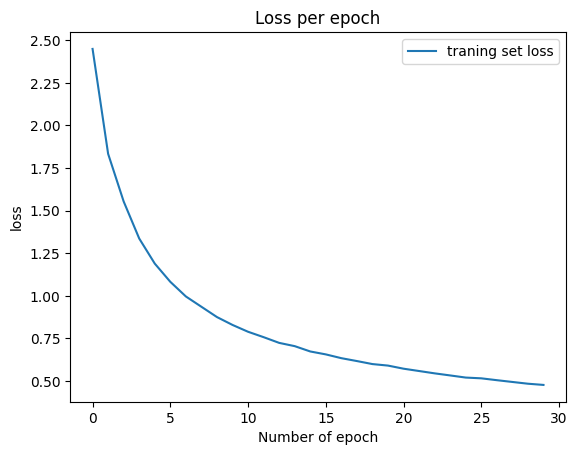

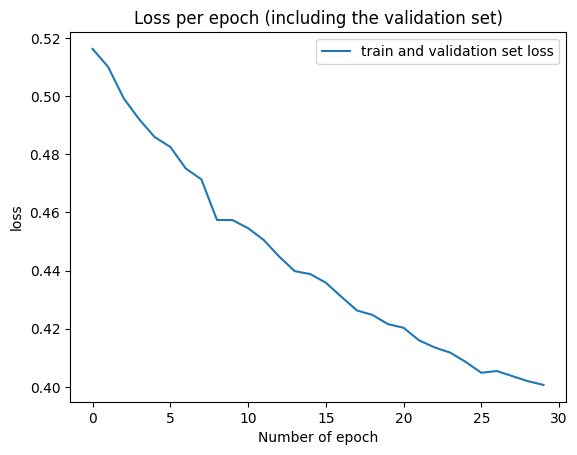

In [10]:
# train the multi-task autoencoder model
model = ML_autoencoder().to(device)
train_model(trainloader, valloader, trainloader_aug, model, base_model_path)

# init OSR model with the trained model and the prediction parameters
model_OSR = ML_autoencoder_OSR(model).to(device)
model_OSR.set_prediction_params(entropy_threshold=0.8, recon_threshold=0.3, temp=1.0)

# Evaluation

In [11]:
#load base model and init the OSR model
model = ML_autoencoder().to(device)
# Fix the size mismatch for mean_entropy and mean_recon_loss
state_dict = torch.load(base_model_path)
for name, weights in state_dict.items():
  if 'mean_entropy' in name or "mean_recon_loss" in name:
    state_dict[name] = weights.view(-1)

model.load_state_dict(state_dict)

# model = ML_autoencoder().to(device)
# model.load_state_dict(torch.load(base_model_path))
model_OSR = ML_autoencoder_OSR(model).to(device)
model_OSR.set_prediction_params(entropy_threshold=0.8, recon_threshold=0.3, temp=1.0)
print("prediction parameters for the OSR model:\n", model_OSR.trained_model.get_mean_entropy(), model_OSR.trained_model.get_mean_recon_loss() )

prediction parameters for the OSR model:
 0.25036224722862244 0.19407996535301208


In [12]:
# test for baseline results
def test(model, test_set, test_loader, doArgmax):
    accuracy = 0
    preds_all = []
    labels_all = []
    for data in test_loader:
        img, labels = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        labels = Variable(labels).to(device)
        recon, preds = model(img)
        if doArgmax:
          preds = torch.argmax(preds, dim=1)
        accuracy += preds.eq(labels).sum().item()

        preds_all.extend(preds.tolist())
        labels_all.extend(labels.tolist())
    accuracy = accuracy / len(test_set)
    return accuracy, preds_all, labels_all

In [13]:
def show_confusion_matrix(labels, preds, display_labels, title):
  conf_matrix_mnist = confusion_matrix(labels, preds, labels=display_labels)
  disp = ConfusionMatrixDisplay(conf_matrix_mnist, display_labels=display_labels)
  disp.plot()
  plt.title(title)
  plt.show()

### Baseline results

In this analysis, we are presenting the baseline accuracy result of the base model, the ML autoencoder, on the MNIST dataset. <br>
Then, we display the baseline accuracy achieved by the OSR model, also evaluated on the MNIST dataset.

Baseline Accuracy for the base model: 95.93%



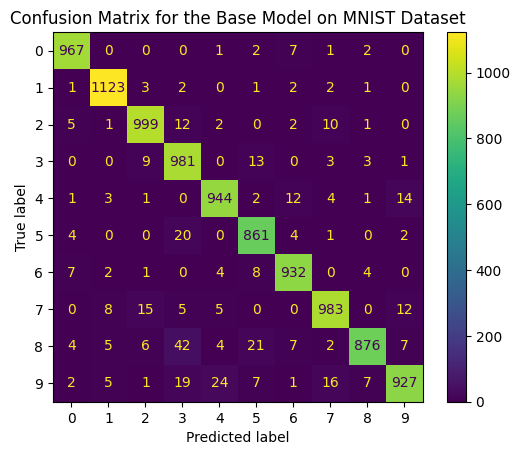

In [14]:
accuracy, preds_all, labels_all = test(model, testset, testloader, True)
print(f'Baseline Accuracy for the base model: {accuracy*100:.2f}%\n')
show_confusion_matrix(labels_all, preds_all, np.arange(10), "Confusion Matrix for the Base Model on MNIST Dataset")

Baseline Accuracy for the OSR model: 95.71%



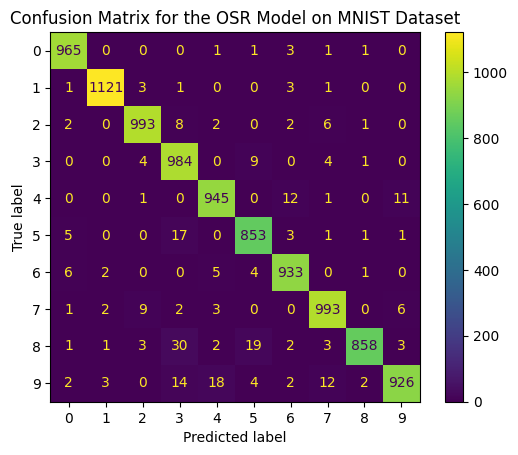

In [23]:
accuracy, preds_all, labels_all = test(model_OSR, testset, testloader, False)
print(f'Baseline Accuracy for the OSR model: {accuracy*100:.2f}%\n')
show_confusion_matrix(labels_all, preds_all, np.arange(10), "Confusion Matrix for the OSR Model on MNIST Dataset")

In [16]:

def eval_model(model, data_loader, device):
    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0
    preds_all = [] # for the confusion matrix
    labels_all = [] # for the confusion matrix

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            data = data.view(data.size(0), -1)
            data = Variable(data).to(device)
            labels = Variable(labels).to(device)
            recon, preds = model(data)

            y_pred = preds

            preds_all.extend(y_pred.tolist())
            labels_all.extend(labels.tolist())

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total, preds_all, labels_all

### OOD Results

In this report, we present the binary classification results and confusion matrix of the OSR model on the combined dataset, mapping all 10 classes from MNIST to "Known" and OSR to "Unknown."

In [24]:
# evaluate the model on the combined dataset
acc_mnist, acc_ood, acc_total,  preds_all, labels_all = eval_model(model_OSR, combined_data_loader, device)

MNIST Accuracy: 95.71%
OOD Accuracy: 90.80%



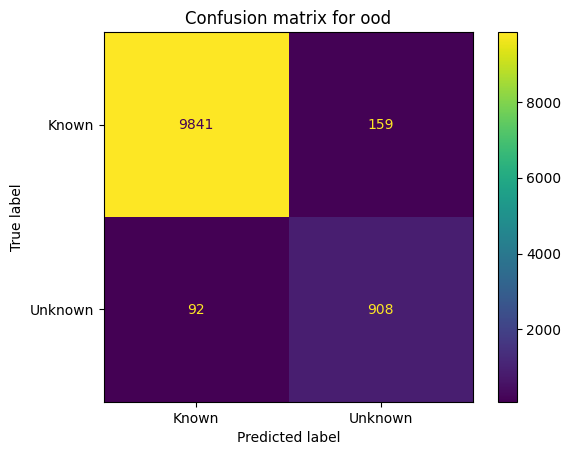

In [25]:
# Binary classification accuracy:
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%\n')

labels_all_bin = np.array(labels_all)
preds_all_bin = np.array(preds_all)

# map labels and prediction to ["Known", "Unknown"] -
# all labels/predictions under 10 are mapped to "Known", and all labels/predictions that are equal to 10 are mapped to "Unknown"
to_binary = lambda l : "Known" if l < 10 else "Unknown"
labels_all_bin = list(map(to_binary, labels_all_bin))
preds_all_bin = list(map(to_binary, preds_all_bin))
show_confusion_matrix(labels_all_bin, preds_all_bin,
                      ["Known", "Unknown"], "Confusion matrix for ood")

### OSR Results

In this evaluation, we assess the total accuracy of the OSR model on both the 10 MNIST classes and the unseen data.




Total Accuracy: 95.26%



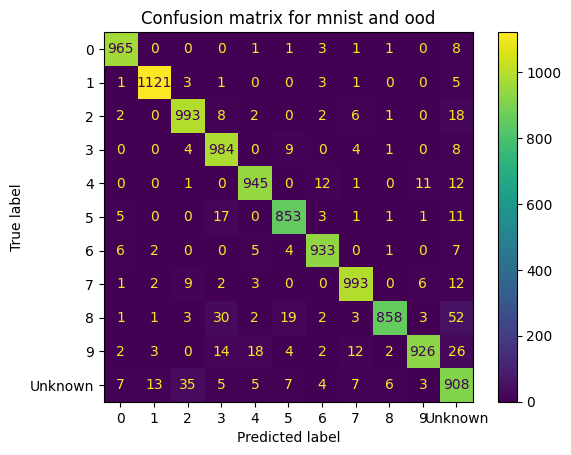

In [26]:
# total accuracy on both the 10 MNIST classes and the unseen data
print(f'Total Accuracy: {acc_total*100:.2f}%\n')

labels_all_total = np.array(labels_all)
preds_all_total = np.array(preds_all)

ten_to_unknown = lambda l : l if l < 10 else "Unknown"
labels_all_total = list(map(ten_to_unknown, labels_all_total))
preds_all_total = list(map(ten_to_unknown, preds_all_total))
show_confusion_matrix(labels_all_total, preds_all_total, [0,1,2,3,4,5,6,7,8,9,"Unknown"], "Confusion matrix for mnist and ood")